# 배틀그라운드 게임 데이터 분석
202055108 김도경, 202055122 민병언

연구목표
1. 각종 데이터의 시각화
2. 순위예측모델 작성
3. 유용한 프로그램 개발

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

%precision 3
%matplotlib inline

In [2]:
data=pd.read_csv('train_V2.csv')

## 데이터 전처리

### 1. 극단적인 값 제거

In [3]:
def removeOutliers(x, column):
    q1 = x[column].quantile(0.25)
    q3 = x[column].quantile(0.75)
    # 10* IQR(Q3 - Q1)
    iqt = 10 * (q3 - q1)
    # 원래 데이터 복제
    y = x
    # 이상치를 NA로 변환
    y[column][(data[column] > (q3 + iqt)) | (data[column] < (q1 - iqt))] = None
    return(y)

In [4]:
removeOutliers(data,'weaponsAcquired')
removeOutliers(data,'kills')
removeOutliers(data,'assists')
removeOutliers(data,'boosts')
removeOutliers(data,'DBNOs')
removeOutliers(data,'heals')
removeOutliers(data,'damageDealt')

<ipython-input-3-566650d29c3a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column][(data[column] > (q3 + iqt)) | (data[column] < (q1 - iqt))] = None
<ipython-input-3-566650d29c3a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column][(data[column] > (q3 + iqt)) | (data[column] < (q1 - iqt))] = None
<ipython-input-3-566650d29c3a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column][(data[column] > (q3 + iqt)) | (data[c

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0.0,0.0,0.00,0.0,0,0.0,60,...,0,0.0000,0,0.000,0,0,244.80,1.0,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0.0,0.0,91.47,0.0,0,0.0,57,...,0,0.0045,0,11.040,0,0,1434.00,5.0,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,NaN,0.0,68.00,0.0,0,0.0,47,...,0,0.0000,0,0.000,0,0,161.80,2.0,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0.0,0.0,32.90,0.0,0,0.0,75,...,0,0.0000,0,0.000,0,0,202.70,3.0,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0.0,0.0,100.00,0.0,0,0.0,45,...,0,0.0000,0,0.000,0,0,49.75,2.0,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0.0,0.0,0.00,0.0,0,0.0,74,...,0,1292.0000,0,0.000,0,0,1019.00,3.0,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0.0,1.0,44.15,0.0,0,0.0,69,...,0,0.0000,0,0.000,0,0,81.70,6.0,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0.0,0.0,59.06,0.0,0,0.0,66,...,0,0.0000,0,2.184,0,0,788.70,4.0,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0.0,4.0,180.40,1.0,1,2.0,11,...,2,0.0000,0,0.000,0,0,2748.00,8.0,0,0.8000


### 2. 매치타입별 이름 통일

In [5]:
map_dictionary ={'solo-fpp' : "solo", 'solo' :"solo", 'duo-fpp' : "duo", 'duo':"duo",'squad-fpp':"squad",'squad':"squad"}    
data['matchType'] = data['matchType'].map(map_dictionary)
data.matchType

0          squad
1          squad
2            duo
3          squad
4           solo
           ...  
4446961    squad
4446962     solo
4446963    squad
4446964    squad
4446965     solo
Name: matchType, Length: 4446966, dtype: object

### 3. 플레이어의 실력별, 매치타입별로 데이터 나누기

In [6]:
data=data.dropna(axis=0)
data_ranked = data[data.rankPoints!=-1]
data_unranked = data[data.rankPoints==-1]

data_top = data_ranked[data_ranked.rankPoints>2499]
data_mid = data_ranked[(data_ranked.rankPoints>1499)&(data_ranked.rankPoints<2500)]
data_bottom = data_ranked[data_ranked.rankPoints<1500]

print(len(data_top),len(data_mid),len(data_bottom),len(data_unranked))

251 1013446 1252712 1375101


In [7]:
group_name = [-2, -1, 1499, 2499, 10000]
group_label = ['unranked','bottom','mid','top']
rank_cut = pd.cut(data.rankPoints, group_name, labels = group_label)
data['rank'] = rank_cut

<ipython-input-7-bcd05beec9f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rank'] = rank_cut


In [8]:
data_top_solo = data_top[data_top.matchType=='solo']
data_top_duo = data_top[data_top.matchType=='duo']
data_top_squad = data_top[data_top.matchType=='squad']

data_mid_solo = data_mid[data_mid.matchType=='solo']
data_mid_duo = data_mid[data_mid.matchType=='duo']
data_mid_squad = data_mid[data_mid.matchType=='squad']

data_bottom_solo = data_bottom[data_bottom.matchType=='solo']
data_bottom_duo = data_bottom[data_bottom.matchType=='duo']
data_bottom_squad = data_bottom[data_bottom.matchType=='squad']

data_unranked_solo = data_unranked[data_unranked.matchType=='solo']
data_unranked_duo = data_unranked[data_unranked.matchType=='duo']
data_unranked_squad = data_unranked[data_unranked.matchType=='squad']

In [87]:
print('unranked_data : ' + str(len(data_unranked)))
print('bottom_data : ' + str(len(data_bottom)))
print('mid_data : ' + str(len(data_mid)))
print('top_data : ' + str(len(data_top)))

unranked_data : 1375101
bottom_data : 1252712
mid_data : 1013446
top_data : 251


    ※ 이후의 발표에서 반드시 필요한 경우를 제외하고 코드를 숨김처리 하였습니다.
    코드는 요청시 공개하도록 하겠습니다. 

----------

# Chapter 1. 데이터 시각화

### 1. 티어별 아군 소생비율

In [9]:
#티어별 기절 및 소생 비율 구하기
# unranked duo play ratio
data_unranked_duo_knocked = data_unranked_duo[data_unranked_duo.DBNOs >= 1]
data_unranked_duo_knocked_revive = data_unranked_duo[(data_unranked_duo.DBNOs >=1)&(data_unranked_duo.revives >=1 )]
data_unranked_duo_ratio = len(data_unranked_duo_knocked_revive)/len(data_unranked_duo_knocked)

# unranked squad play ratio
data_unranked_squad_knocked = data_unranked_squad[data_unranked_squad.DBNOs >= 1]
data_unranked_squad_knocked_revive = data_unranked_squad[(data_unranked_squad.DBNOs >=1)&(data_unranked_squad.revives >=1 )]
data_unranked_squad_ratio = len(data_unranked_squad_knocked_revive)/len(data_unranked_squad_knocked)

# bottom duo play ratio
data_bottom_duo_knocked = data_bottom_duo[data_bottom_duo.DBNOs >= 1]
data_bottom_duo_knocked_revive = data_bottom_duo[(data_bottom_duo.DBNOs >=1)&(data_bottom_duo.revives >=1 )]
data_bottom_duo_ratio = len(data_bottom_duo_knocked_revive)/len(data_bottom_duo_knocked)

# bottom squad play ratio
data_bottom_squad_knocked = data_bottom_squad[data_bottom_squad.DBNOs >= 1]
data_bottom_squad_knocked_revive = data_bottom_squad[(data_bottom_squad.DBNOs >=1)&(data_bottom_squad.revives >=1 )]
data_bottom_squad_ratio = len(data_bottom_squad_knocked_revive)/len(data_bottom_squad_knocked)

# mid duo play ratio
data_mid_duo_knocked = data_mid_duo[data_mid_duo.DBNOs >= 1]
data_mid_duo_knocked_revive = data_mid_duo[(data_mid_duo.DBNOs >=1)&(data_mid_duo.revives >=1 )]
data_mid_duo_ratio = len(data_mid_duo_knocked_revive)/len(data_mid_duo_knocked)

# mid squad play ratio
data_mid_squad_knocked = data_mid_squad[data_mid_squad.DBNOs >= 1]
data_mid_squad_knocked_revive = data_mid_squad[(data_mid_squad.DBNOs >=1)&(data_mid_squad.revives >=1 )]
data_mid_squad_ratio = len(data_mid_squad_knocked_revive)/len(data_mid_squad_knocked)

# top duo play ratio
data_top_duo_knocked = data_top_duo[data_top_duo.DBNOs >= 1]
data_top_duo_knocked_revive = data_top_duo[(data_top_duo.DBNOs >=1)&(data_top_duo.revives >=1 )]
data_top_duo_ratio = len(data_top_duo_knocked_revive)/len(data_top_duo_knocked)

# top squad play ratio
data_top_squad_knocked = data_top_squad[data_top_squad.DBNOs >= 1]
data_top_squad_knocked_revive = data_top_squad[(data_top_squad.DBNOs >=1)&(data_top_squad.revives >=1 )]
data_top_squad_ratio = len(data_top_squad_knocked_revive)/len(data_top_squad_knocked)

티어별 아군 소생비율 - 듀오모드

Text(0.5, 1.0, 'ratio between knocked down and revive in duo play')

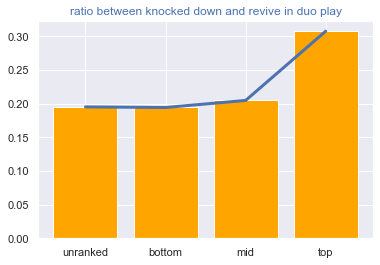

In [10]:
x = ['unranked','bottom','mid','top']
ratio_duo = [data_unranked_duo_ratio, data_bottom_duo_ratio, data_mid_duo_ratio, data_top_duo_ratio]
plt_duo = plt.bar(x = x, height = ratio_duo, label = 'duo', color='orange')
plt_duo_plot = plt.plot(x, ratio_duo, label = 'duo', linewidth = 3)
plt.title('ratio between knocked down and revive in duo play',color='b')

티어별 아군 소생비율 - 스쿼드모드

Text(0.5, 1.0, 'ratio between knocked down and revive in squad play')

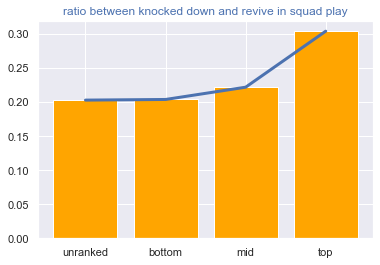

In [11]:
ratio_squad = [data_unranked_squad_ratio, data_bottom_squad_ratio, data_mid_squad_ratio, data_top_squad_ratio]
plt_squad = plt.bar(x = x,height = ratio_squad, label = 'squad', color = 'orange')
plt_squad_plot = plt.plot(x,ratio_squad, label = 'squad',linewidth = 3)
plt.title('ratio between knocked down and revive in squad play', color='b')

---

### 2. 티어별 평균 킬 수

In [12]:
# 티어별 킬 수 평균 구하기
# unranked solo kill
data_unranked_solo_kill = data_unranked_solo['kills'].mean()

# unranked duo kill
data_unranked_duo_kill = data_unranked_duo['kills'].mean()

# unranked squad play ratio
data_unranked_squad_kill = data_unranked_squad['kills'].mean()

# bottom solo play ratio
data_bottom_solo_kill = data_bottom_solo['kills'].mean()

# bottom duo play ratio
data_bottom_duo_kill = data_bottom_duo['kills'].mean()

# bottom squad play ratio
data_bottom_squad_kill = data_bottom_squad['kills'].mean()

# mid solo play ratio
data_mid_solo_kill = data_mid_solo['kills'].mean()

# mid duo play ratio
data_mid_duo_kill = data_mid_duo['kills'].mean()

# mid squad play ratio
data_mid_squad_kill = data_mid_squad['kills'].mean()

# top solo play ratio
data_top_solo_kill = data_top_solo['kills'].mean()
# top duo play ratio
data_top_duo_kill = data_top_duo['kills'].mean()

# top squad play ratio
data_top_squad_kill = data_top_squad['kills'].mean()

티어별 평균 킬수 - 솔로모드

Text(0.5, 1.0, 'kills betwwen tier in solo play')

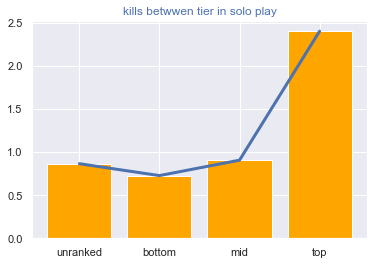

In [13]:
x = ['unranked','bottom','mid','top']
average_kill_solo = [data_unranked_solo_kill, data_bottom_solo_kill, data_mid_solo_kill, data_top_solo_kill]

plt_kill_s = plt.bar(x = x, height = average_kill_solo, label = 'solo', color = 'orange')
plt_plot_s = plt.plot(x, average_kill_solo, linewidth = 3)
plt.title('kills betwwen tier in solo play', color='b')

티어별 평균 킬수 - 듀오모드

Text(0.5, 1.0, 'kills between tier in duo play')

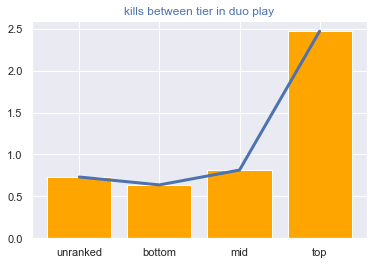

In [14]:
x = ['unranked','bottom','mid','top']
average_kill_duo = [data_unranked_duo_kill, data_bottom_duo_kill, data_mid_duo_kill, data_top_duo_kill]

plt_kill_d = plt.bar(x = x, height = average_kill_duo, label = 'solo', color = 'orange')
plt_plot_d = plt.plot(x, average_kill_duo, linewidth = 3)
plt.title('kills between tier in duo play',color='b')

티어별 평균 킬수 - 스쿼드모드

Text(0.5, 1.0, 'kills between tier in squad play')

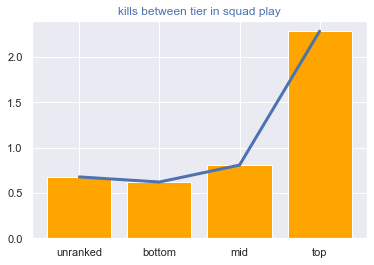

In [15]:
x = ['unranked','bottom','mid','top']
average_kill_squad = [data_unranked_squad_kill, data_bottom_squad_kill, data_mid_squad_kill, data_top_squad_kill]

plt_kill_sq = plt.bar(x = x, height = average_kill_squad, label = 'solo', color = 'orange')
plt_plot_sq = plt.plot(x, average_kill_squad, linewidth = 3)
plt.title('kills between tier in squad play',color='b')

-----

### 3. 티어별 평균 헤드샷 킬 수

In [16]:
# 티어별 헤드샷 평균 구하기
#unranked_solo
hs_un_s = data_unranked_solo['headshotKills'].mean()

#unranked_duo
hs_un_d = data_unranked_duo['headshotKills'].mean()

#unranked_squad
hs_un_sq = data_unranked_squad['headshotKills'].mean()

#bottom_solo
hs_bt_s = data_bottom_solo['headshotKills'].mean()

#bottom_duo
hs_bt_d = data_bottom_duo['headshotKills'].mean()

#bottom_squad
hs_bt_sq = data_bottom_squad['headshotKills'].mean()

#mid_solo
hs_m_s = data_mid_solo['headshotKills'].mean()

#mid_duo
hs_m_d = data_mid_duo['headshotKills'].mean()

#mid_squad
hs_m_sq = data_mid_squad['headshotKills'].mean()

#top_solo
hs_t_s = data_top_solo['headshotKills'].mean()

#top_duo
hs_t_d = data_top_duo['headshotKills'].mean()

#top_squad
hs_t_sq = data_top_squad['headshotKills'].mean()

티어별 평균 헤드샷 킬 수 - 솔로모드

Text(0.5, 1.0, 'headShotkills between tier in solo play')

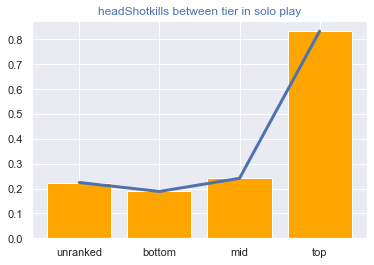

In [17]:
x = ['unranked','bottom','mid','top']
average_hs_solo = [hs_un_s, hs_bt_s, hs_m_s, hs_t_s]

plt_hs_s = plt.bar(x = x, height = average_hs_solo, label = 'solo', color = 'orange')
plt_plot_s = plt.plot(x, average_hs_solo, linewidth = 3)
plt.title('headShotkills between tier in solo play',color='b')

티어별 평균 헤드샷 킬 수 - 듀오모드

Text(0.5, 1.0, 'headShotkills between tier in duo play')

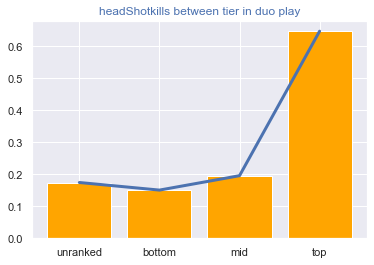

In [18]:
x = ['unranked','bottom','mid','top']
average_hs_duo = [hs_un_d, hs_bt_d, hs_m_d, hs_t_d]

plt_hs_d = plt.bar(x = x, height = average_hs_duo, label = 'solo', color = 'orange')
plt_plot_d = plt.plot(x, average_hs_duo, linewidth = 3)
plt.title('headShotkills between tier in duo play',color='b')

티어별 평균 헤드샷 킬 수 - 스쿼드모드

Text(0.5, 1.0, 'headShotkills between tier in squad play')

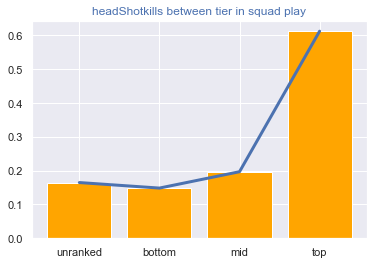

In [19]:
x = ['unranked','bottom','mid','top']
average_hs_squad = [hs_un_sq, hs_bt_sq, hs_m_sq, hs_t_sq]

plt_hs_sq = plt.bar(x = x, height = average_hs_squad, label = 'solo', color = 'orange')
plt_plot_sq = plt.plot(x, average_hs_squad, linewidth = 3)
plt.title('headShotkills between tier in squad play',color='b')

----

### 4. 티어별 평균 무기 획득량

In [20]:
# 티어별 무기 획득량 평균 구하기
ac_un_s = data_unranked_solo['weaponsAcquired'].mean()
ac_un_d = data_unranked_duo['weaponsAcquired'].mean()
ac_un_sq = data_unranked_squad['weaponsAcquired'].mean()

ac_bt_s = data_bottom_solo['weaponsAcquired'].mean()
ac_bt_d = data_bottom_duo['weaponsAcquired'].mean()
ac_bt_sq = data_bottom_squad['weaponsAcquired'].mean()

ac_m_s = data_mid_solo['weaponsAcquired'].mean()
ac_m_d = data_mid_duo['weaponsAcquired'].mean()
ac_m_sq = data_mid_squad['weaponsAcquired'].mean()

ac_t_s = data_top_solo['weaponsAcquired'].mean()
ac_t_d = data_top_duo['weaponsAcquired'].mean()
ac_t_sq = data_top_squad['weaponsAcquired'].mean()

티어별 평균 무기획득량 - 솔로모드

Text(0.5, 1.0, 'acquired Weapons between tiers in solo play')

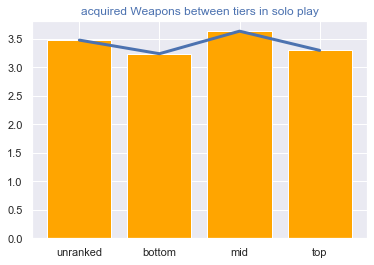

In [21]:
x = ['unranked','bottom','mid','top']
average_ac_solo= [ac_un_s, ac_bt_s, ac_m_s, ac_t_s]

plt_ac_s = plt.bar(x = x, height = average_ac_solo, label = 'solo', color = 'orange')
plt_plot_s = plt.plot(x, average_ac_solo, linewidth = 3)
plt.title('acquired Weapons between tiers in solo play',color='b')

티어별 평균 무기획득량 - 듀오모드

Text(0.5, 1.0, 'acquired Weapons between tiers in duo play')

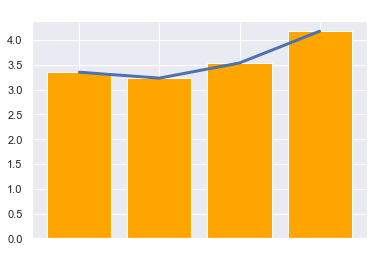

In [22]:
x = ['unranked','bottom','mid','top']
average_ac_duo= [ac_un_d, ac_bt_d, ac_m_d, ac_t_d]

plt_ac_d = plt.bar(x = x, height = average_ac_duo, label = 'solo', color = 'orange')
plt_plot_d = plt.plot(x, average_ac_duo, linewidth = 3)
plt.xticks(fontsize = 10, color = 'w')

plt.title('acquired Weapons between tiers in duo play',color='w')

티어별 평균 무기획득량 - 스쿼드모드

Text(0.5, 1.0, 'acquired Weapons between tiers in squad play')

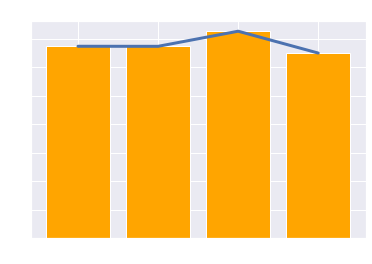

In [23]:
# 티어별 무기 획득량 스쿼드
x = ['unranked','bottom','mid','top']
average_ac_squad= [ac_un_sq, ac_bt_sq, ac_m_sq, ac_t_sq]

plt_ac_sq = plt.bar(x = x, height = average_ac_squad, label = 'solo', color = 'orange')
plt_plot_sq = plt.plot(x, average_ac_squad, linewidth = 3)
plt.xticks(fontsize = 10, color = 'w')
plt.yticks(fontsize = 10, color = 'w')
plt.title('acquired Weapons between tiers in squad play',color='w')

----

### 5. 티어별 적에게 가한 평균 피해량

In [24]:
# 티어별 데미지 딜량 평균 구하기
dD_un_s = data_unranked_solo['damageDealt'].mean()
dD_un_d = data_unranked_duo['damageDealt'].mean()
dD_un_sq = data_unranked_squad['damageDealt'].mean()

dD_bt_s = data_bottom_solo['damageDealt'].mean()
dD_bt_d = data_bottom_duo['damageDealt'].mean()
dD_bt_sq = data_bottom_squad['damageDealt'].mean()

dD_m_s = data_mid_solo['damageDealt'].mean()
dD_m_d = data_mid_duo['damageDealt'].mean()
dD_m_sq = data_mid_squad['damageDealt'].mean()

dD_t_s = data_top_solo['damageDealt'].mean()
dD_t_d = data_top_duo['damageDealt'].mean()
dD_t_sq = data_top_squad['damageDealt'].mean()

티어별 적에게 가한 평균 피해량 - 솔로모드

Text(0.5, 1.0, 'damageDealt between tiers in solo play')

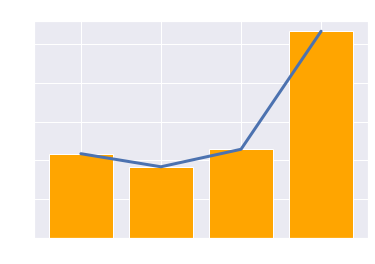

In [25]:
x = ['unranked','bottom','mid','top']
average_dD_solo= [dD_un_s, dD_bt_s, dD_m_s, dD_t_s]

plt_dD_s = plt.bar(x = x, height = average_dD_solo, label = 'solo', color = 'orange')
plt_plot_s = plt.plot(x, average_dD_solo, linewidth = 3)
plt.xticks(fontsize = 10, color = 'w')
plt.yticks(fontsize = 10, color = 'w')
plt.title('damageDealt between tiers in solo play',color='w')

티어별 적에게 가한 평균 피해량 - 듀오모드

Text(0.5, 1.0, 'damageDealt between tiers in duo play')

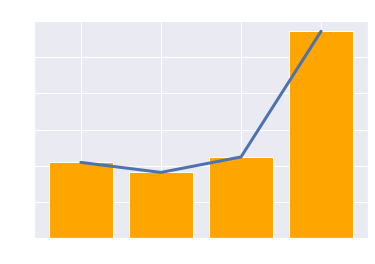

In [26]:
x = ['unranked','bottom','mid','top']
average_dD_duo= [dD_un_d, dD_bt_d, dD_m_d, dD_t_d]

plt_dD_d = plt.bar(x = x, height = average_dD_duo, label = 'solo', color = 'orange')
plt_plot_d = plt.plot(x, average_dD_duo, linewidth = 3)
plt.xticks(fontsize = 10, color = 'w')
plt.yticks(fontsize = 10, color = 'w')
plt.title('damageDealt between tiers in duo play',color='w')

티어별 적에게 가한 평균 피해량 - 스쿼드모드

Text(0.5, 1.0, 'damageDealt between tiers in squad play')

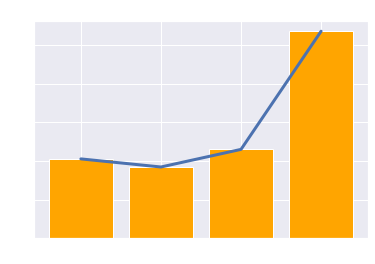

In [27]:
x = ['unranked','bottom','mid','top']
average_dD_squad= [dD_un_sq, dD_bt_sq, dD_m_sq, dD_t_sq]

plt_dD_sq = plt.bar(x = x, height = average_dD_squad, label = 'solo', color = 'orange')
plt_plot_sq = plt.plot(x, average_dD_squad, linewidth = 3)
plt.xticks(fontsize = 10, color = 'w')
plt.yticks(fontsize = 10, color = 'w')
plt.title('damageDealt between tiers in squad play',color='w')

-----

### 6. 티어별 회복아이템 평균 사용량

In [28]:
# 티어별 회복 아이템 평균 사용량 구하기
heal_un_s = data_unranked_solo['heals'].mean()
heal_un_d = data_unranked_duo['heals'].mean()
heal_un_sq = data_unranked_squad['heals'].mean()

heal_bt_s = data_bottom_solo['heals'].mean()
heal_bt_d = data_bottom_duo['heals'].mean()
heal_bt_sq = data_bottom_squad['heals'].mean()

heal_m_s = data_mid_solo['heals'].mean()
heal_m_d = data_mid_duo['heals'].mean()
heal_m_sq = data_mid_squad['heals'].mean()

heal_t_s = data_top_solo['heals'].mean()
heal_t_d = data_top_duo['heals'].mean()
heal_t_sq = data_top_squad['heals'].mean()

티어별 회복아이템 평균 사용량 - 솔로모드

Text(0.5, 1.0, 'usage of heal item between tiers in solo play')

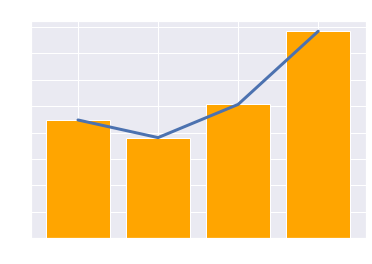

In [29]:
x = ['unranked','bottom','mid','top']
average_heal_solo= [heal_un_s, heal_bt_s, heal_m_s, heal_t_s]

plt_heal_s = plt.bar(x = x, height = average_heal_solo, label = 'solo', color = 'orange')
plt_plot_s = plt.plot(x, average_heal_solo, linewidth = 3)
plt.xticks(fontsize = 10, color = 'w')
plt.yticks(fontsize = 10, color = 'w')
plt.title('usage of heal item between tiers in solo play',color='w')

티어별 회복아이템 평균 사용량 - 듀오모드

Text(0.5, 1.0, 'usage of heal item between tiers in duo play')

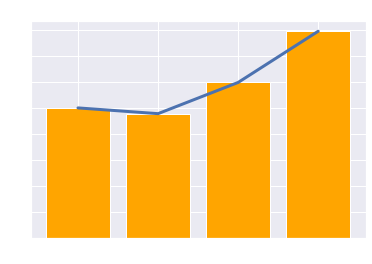

In [30]:
x = ['unranked','bottom','mid','top']
average_heal_duo= [heal_un_d, heal_bt_d, heal_m_d, heal_t_d]

plt_heal_d = plt.bar(x = x, height = average_heal_duo, label = 'solo', color = 'orange')
plt_plot_d = plt.plot(x, average_heal_duo, linewidth = 3)
plt.xticks(fontsize = 10, color = 'w')
plt.yticks(fontsize = 10, color = 'w')
plt.title('usage of heal item between tiers in duo play',color='w')

티어별 회복아이템 평균 사용량 - 스쿼드모드

Text(0.5, 1.0, 'usage of heal item between tiers in squad play')

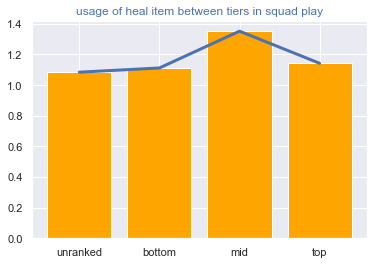

In [31]:
x = ['unranked','bottom','mid','top']
average_heal_squad= [heal_un_sq, heal_bt_sq, heal_m_sq, heal_t_sq]

plt_heal_sq = plt.bar(x = x, height = average_heal_squad, label = 'solo', color = 'orange')
plt_plot_sq = plt.plot(x, average_heal_squad, linewidth = 3)

plt.title('usage of heal item between tiers in squad play',color='b')

----

### 7. 각 요소별 상관관계 비교

In [32]:
# 상관관계 비교 데이터 전처리
data2 = data.iloc[:,5:8]
data3 = data.iloc[:,11:12]
data4 = data.iloc[:,19:20]
data5 = data.iloc[:,26:27]
data6 = data.loc[:, ['rank']]
data7 = pd.concat([data2, data3, data4, data5, data6], axis = 1)
data7 = data7.sample(n=30000)

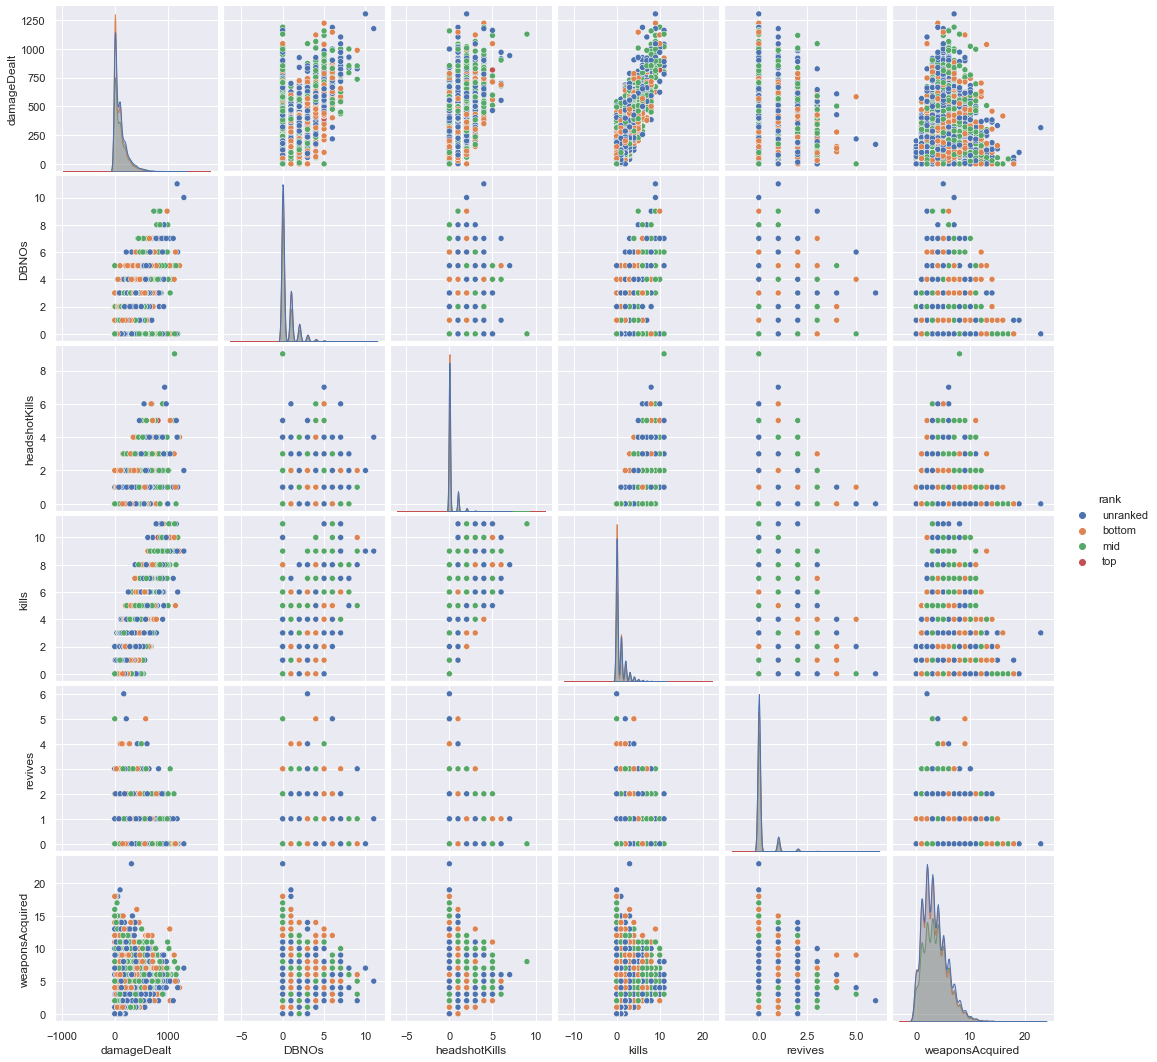

In [33]:
sns.pairplot(data7, hue = 'rank')

데미지와 기절, 데미지와 킬, 헤드샷과 킬간에 상관관계가 있는 것을 알 수 있다.

------

# Chapter 2. 순위예측모델
<br>
플레이어의 실력, 매치타입별 최적의 순위예측모델 작성

### 1. 언랭 (랭크포인트가 0점인 사람들)

언랭 - 솔로모드

In [34]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
weaponsAcquired,205824.752491
boosts,207261.440410
damageDealt,222278.913007
kills,222973.839591
heals,228517.827837


In [35]:
pd.DataFrame({'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + damageDealt':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + damageDealt", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + damageDealt + kills':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + damageDealt + kills", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + damageDealt + kills + heals':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + damageDealt + kills + heals", data = data_unranked_solo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
weaponsAcquired + boosts + damageDealt + kills + heals,188962.527279
weaponsAcquired + boosts + damageDealt + kills,189131.628685
weaponsAcquired + boosts + damageDealt,189142.602779
weaponsAcquired + boosts,190597.313162
weaponsAcquired,205824.752491


-----

언랭 - 듀오모드

In [36]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'assists':[smf.glm(formula = "winPlacePerc ~ assists", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'DBNOs':[smf.glm(formula = "winPlacePerc ~ DBNOs", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
weaponsAcquired,358592.976593
boosts,362724.573592
heals,392451.365151
damageDealt,396181.143117
kills,397655.355276
DBNOs,407480.511811
assists,420709.339545


In [37]:
pd.DataFrame({'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals + damageDealt':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals + damageDealt + kills':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt + kills", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs + assists':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs + assists", data = data_unranked_duo, family=sm.families.Binomial()).fit().aic],},index=['aic']).transpose().sort_values(by='aic')

,aic
weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs + assists,334180.622984
weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs,334180.622984
weaponsAcquired + boosts + heals + damageDealt + kills,334325.841434
weaponsAcquired + boosts + heals + damageDealt,334411.030898
weaponsAcquired + boosts + heals,335290.101404
weaponsAcquired + boosts,335833.690163
weaponsAcquired,358592.976593


------

언랭 - 스쿼드모드

In [38]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'assists':[smf.glm(formula = "winPlacePerc ~ assists", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'DBNOs':[smf.glm(formula = "winPlacePerc ~ DBNOs", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts,682047.487142
weaponsAcquired,683080.030569
heals,735055.544198
damageDealt,753530.814475
kills,755939.131500
DBNOs,768873.634657
assists,786392.627686


In [39]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists", data = data_unranked_squad, family=sm.families.Binomial()).fit().aic],},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs,635502.299856
boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists,635502.299856
boosts + weaponsAcquired + heals + damageDealt + kills,636334.926204
boosts + weaponsAcquired + heals + damageDealt,636585.124201
boosts + weaponsAcquired + heals,637623.550242
boosts + weaponsAcquired,639074.294142
boosts,682047.487142


-----

### 2. 하위티어 (브론즈 - 하위 15%)

하위티어 - 솔로모드

In [40]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
weaponsAcquired,114411.557630
boosts,117477.416673
damageDealt,124225.515959
kills,124565.219377
heals,127207.605069


In [41]:
pd.DataFrame({'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + damageDealt':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + damageDealt", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + damageDealt + kills':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + damageDealt + kills", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + damageDealt + kills + heals':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + damageDealt + kills + heals", data = data_bottom_solo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
weaponsAcquired + boosts + damageDealt + kills + heals,106773.136690
weaponsAcquired + boosts + damageDealt + kills,106879.602955
weaponsAcquired + boosts + damageDealt,106883.000822
weaponsAcquired + boosts,107603.142899
weaponsAcquired,114411.557630


----

하위티어 - 듀오모드

In [42]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'assists':[smf.glm(formula = "winPlacePerc ~ assists", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'DBNOs':[smf.glm(formula = "winPlacePerc ~ DBNOs", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
weaponsAcquired,278667.890516
boosts,283908.830331
heals,305206.394707
damageDealt,310198.307065
kills,310888.057220
DBNOs,317640.382216
assists,326606.381840


In [43]:
pd.DataFrame({'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals + damageDealt':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals + damageDealt + kills':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt + kills", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs + assists':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs + assists", data = data_bottom_duo, family=sm.families.Binomial()).fit().aic],},index=['aic']).transpose().sort_values(by='aic')

,aic
weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs,261585.912531
weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs + assists,261585.912531
weaponsAcquired + boosts + heals + damageDealt + kills,261657.455903
weaponsAcquired + boosts + heals + damageDealt,261702.217034
weaponsAcquired + boosts + heals,262214.309835
weaponsAcquired + boosts,262718.915648
weaponsAcquired,278667.890516


-----

하위티어 - 스쿼드모드

In [44]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'assists':[smf.glm(formula = "winPlacePerc ~ assists", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'DBNOs':[smf.glm(formula = "winPlacePerc ~ DBNOs", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts,730233.731179
weaponsAcquired,732030.839236
heals,785525.451967
damageDealt,810155.136441
kills,810950.330807
DBNOs,822959.312194
assists,839190.195844


In [45]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists", data = data_bottom_squad, family=sm.families.Binomial()).fit().aic],},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists,682420.975701
boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs,682420.975701
boosts + weaponsAcquired + heals + damageDealt + kills,683073.233712
boosts + weaponsAcquired + heals + damageDealt,683276.371802
boosts + weaponsAcquired + heals,684059.898739
boosts + weaponsAcquired,685718.190802
boosts,730233.731179


----

### 3. 중위티어 (실버, 골드 - 대부분의 플레이어가 존재하는 구간)

중위티어 - 솔로모드

In [46]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_mid_solo, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_mid_solo, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_mid_solo, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_mid_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_mid_solo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts,285188.885138
weaponsAcquired,291076.684192
kills,308505.308033
damageDealt,311158.201497
heals,317429.794285


In [47]:
pd.DataFrame({'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_mid_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts", data = data_mid_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + kills':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + kills", data = data_mid_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + kills + damageDealt':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + kills + damageDealt", data = data_mid_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired + boosts + kills + damageDealt + heals':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + kills + damageDealt + heals", data = data_mid_solo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
weaponsAcquired + boosts + kills + damageDealt + heals,263560.631765
weaponsAcquired + boosts + kills + damageDealt,263869.847264
weaponsAcquired + boosts + kills,263873.714423
weaponsAcquired + boosts,265928.449241
weaponsAcquired,291076.684192


-----

중위티어 - 듀오모드

In [48]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'assists':[smf.glm(formula = "winPlacePerc ~ assists", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'DBNOs':[smf.glm(formula = "winPlacePerc ~ DBNOs", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_mid_duo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts,339086.511948
weaponsAcquired,339410.072439
heals,370420.831887
damageDealt,373962.093881
kills,374153.662908
DBNOs,384101.147136
assists,397754.596455


In [49]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists", data = data_mid_duo, family=sm.families.Binomial()).fit().aic],},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs,314141.631063
boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists,314141.631063
boosts + weaponsAcquired + heals + damageDealt + kills,314283.330971
boosts + weaponsAcquired + heals + damageDealt,314390.240899
boosts + weaponsAcquired + heals,315156.268079
boosts + weaponsAcquired,315569.555922
boosts,339086.511948


---

중위티어 - 스쿼드모드

In [50]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'assists':[smf.glm(formula = "winPlacePerc ~ assists", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'DBNOs':[smf.glm(formula = "winPlacePerc ~ DBNOs", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_mid_squad, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts,298848.732037
weaponsAcquired,304631.727137
heals,324377.661363
damageDealt,330523.203570
kills,330837.360112
DBNOs,337185.532513
assists,346937.780894


In [51]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists':[smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists", data = data_mid_squad, family=sm.families.Binomial()).fit().aic],},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs,281402.386237
boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists,281402.386237
boosts + weaponsAcquired + heals + damageDealt + kills,281796.547564
boosts + weaponsAcquired + heals + damageDealt,281942.773300
boosts + weaponsAcquired + heals,282547.672823
boosts + weaponsAcquired,283019.644753
boosts,298848.732037


-----

### 4. 상위티어 (플래티넘, 다이아몬드, 마스터 - 상위 10%)

상위티어 - 솔로모드

In [52]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_top_solo, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_top_solo, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_top_solo, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_top_solo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_top_solo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
kills,26.031902
damageDealt,27.735165
boosts,28.297624
weaponsAcquired,29.319478
heals,31.140668


In [53]:
pd.DataFrame({'kills':[smf.glm(formula = "winPlacePerc ~ kills", data = data_top_solo, family=sm.families.Binomial()).fit().aic],
              'kills + damageDealt':[smf.glm(formula = "winPlacePerc ~ kills + damageDealt", data = data_top_solo, family=sm.families.Binomial()).fit().aic],
              'kills + damageDealt + boosts':[smf.glm(formula = "winPlacePerc ~ kills + damageDealt + boosts", data = data_top_solo, family=sm.families.Binomial()).fit().aic],
              'kills + damageDealt + boosts + weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ kills + damageDealt + boosts + weaponsAcquired", data = data_top_solo, family=sm.families.Binomial()).fit().aic],
              'kills + damageDealt + boosts + weaponsAcquired + heals':[smf.glm(formula = "winPlacePerc ~ kills + damageDealt + boosts + weaponsAcquired + heals", data = data_top_solo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
kills,26.031902
kills + damageDealt,27.639355
kills + damageDealt + boosts,28.517849
kills + damageDealt + boosts + weaponsAcquired,29.576030
kills + damageDealt + boosts + weaponsAcquired + heals,31.513041


---

상위티어 - 듀오모드

In [54]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'assists':[smf.glm(formula = "winPlacePerc ~ assists", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'DBNOs':[smf.glm(formula = "winPlacePerc ~ DBNOs", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_top_duo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
kills,18.979774
weaponsAcquired,19.190297
damageDealt,19.306714
assists,19.885015
boosts,20.293996
heals,20.310905
DBNOs,21.135408


In [55]:
pd.DataFrame({'kills':[smf.glm(formula = "winPlacePerc ~ kills", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'kills + weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ kills + weaponsAcquired", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'kills + weaponsAcquired + damageDealt':[smf.glm(formula = "winPlacePerc ~ kills + weaponsAcquired + damageDealt", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'kills + weaponsAcquired + damageDealt + assists':[smf.glm(formula = "winPlacePerc ~ kills + weaponsAcquired + damageDealt + assists", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'kills + weaponsAcquired + damageDealt + assists + boosts':[smf.glm(formula = "winPlacePerc ~ kills + weaponsAcquired + damageDealt + assists + boosts", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'kills + weaponsAcquired + damageDealt + assists + boosts + heals':[smf.glm(formula = "winPlacePerc ~ kills + weaponsAcquired + damageDealt + assists + boosts + heals", data = data_top_duo, family=sm.families.Binomial()).fit().aic],
              'kills + weaponsAcquired + damageDealt + assists + boosts + heals + DBNOs':[smf.glm(formula = "winPlacePerc ~ kills + weaponsAcquired + damageDealt + assists + boosts + heals + DBNOs", data = data_top_duo, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
kills,18.979774
kills + weaponsAcquired,20.509603
kills + weaponsAcquired + damageDealt,22.306158
kills + weaponsAcquired + damageDealt + assists,22.306158
kills + weaponsAcquired + damageDealt + assists + boosts,24.306157
kills + weaponsAcquired + damageDealt + assists + boosts + heals,26.284981
kills + weaponsAcquired + damageDealt + assists + boosts + heals + DBNOs,27.024997


-----

상위티어 - 스쿼드모드

In [56]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'damageDealt':[smf.glm(formula = "winPlacePerc ~ damageDealt", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'heals':[smf.glm(formula = "winPlacePerc ~ heals", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'kills': [smf.glm(formula = "winPlacePerc ~ kills", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'assists':[smf.glm(formula = "winPlacePerc ~ assists", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'DBNOs':[smf.glm(formula = "winPlacePerc ~ DBNOs", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ weaponsAcquired", data = data_top_squad, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts,188.256190
kills,200.447861
damageDealt,204.423189
weaponsAcquired,206.927373
heals,208.756182
DBNOs,214.518320
assists,231.047590


In [57]:
pd.DataFrame({'boosts':[smf.glm(formula = "winPlacePerc ~ boosts", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + kills':[smf.glm(formula = "winPlacePerc ~ boosts + kills", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + kills + damageDealt':[smf.glm(formula = "winPlacePerc ~ boosts + kills + damageDealt", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + kills + damageDealt + heals':[smf.glm(formula = "winPlacePerc ~ boosts + kills + damageDealt + heals", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + kills + damageDealt + heals + weaponsAcquired':[smf.glm(formula = "winPlacePerc ~ boosts + kills + damageDealt + heals + weaponsAcquired", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + kills + damageDealt + heals + weaponsAcquired + DBNOs':[smf.glm(formula = "winPlacePerc ~ boosts + kills + damageDealt + heals + weaponsAcquired + DBNOs", data = data_top_squad, family=sm.families.Binomial()).fit().aic],
              'boosts + kills + damageDealt + heals + weaponsAcquired + DBNOs + assists':[smf.glm(formula = "winPlacePerc ~ boosts + kills + damageDealt + heals + weaponsAcquired + DBNOs + assists", data = data_top_squad, family=sm.families.Binomial()).fit().aic]},index=['aic']).transpose().sort_values(by='aic')

,aic
boosts + kills,186.211326
boosts + kills + damageDealt + heals + weaponsAcquired,187.993691
boosts + kills + damageDealt,188.209050
boosts,188.256190
boosts + kills + damageDealt + heals + weaponsAcquired + DBNOs,189.000281
boosts + kills + damageDealt + heals + weaponsAcquired + DBNOs + assists,189.000281
boosts + kills + damageDealt + heals,189.901205


------

### 결과정리

순위에 가장 큰 영향을 미치는 요인

In [58]:
pd.DataFrame({'solo':['무기획득량','무기획득량','무기획득량','처치 수'],
             'duo':['무기획득량','무기획득량','부스트','처치 수'],
             'squad':['부스트','부스트','부스트','부스트']},index=['unranked','bottom','mid','top'])

,solo,duo,squad
unranked,무기획득량,무기획득량,부스트
bottom,무기획득량,무기획득량,부스트
mid,무기획득량,부스트,부스트
top,처치 수,처치 수,부스트


가장 우수한 순위예측모델

In [59]:
pd.DataFrame({'solo':['무기획득량 + 부스트 + 적에게 가한 피해량 + 처치 수 + 회복아이템 사용량','무기획득량 + 부스트 + 적에게 가한 피해량 + 처치 수 + 회복아이템 사용량','무기획득량 + 부스트 + 처치 수 + 적에게 가한 피해량 + 회복아이템 사용량','처치 수'],
             'duo':['무기획득량 + 부스트 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절','무기획득량 + 부스트 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절','부스트 + 무기획득량 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절 + 어시스트','처치 수'],
             'squad':['부스트 + 무기획득량 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절','부스트 + 무기획득량 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절 + 어시스트','부스트 + 무기획득량 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절','부스트']},index=['unranked','bottom','mid','top'])

,solo,duo,squad
unranked,무기획득량 + 부스트 + 적에게 가한 피해량 + 처치 수 + 회복아이템 사용량,무기획득량 + 부스트 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절,부스트 + 무기획득량 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절
bottom,무기획득량 + 부스트 + 적에게 가한 피해량 + 처치 수 + 회복아이템 사용량,무기획득량 + 부스트 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절,부스트 + 무기획득량 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + ...
mid,무기획득량 + 부스트 + 처치 수 + 적에게 가한 피해량 + 회복아이템 사용량,부스트 + 무기획득량 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + ...,부스트 + 무기획득량 + 회복아이템 사용량 + 적에게 가한 피해량 + 처치 수 + 기절
top,처치 수,처치 수,부스트


In [60]:
model_unranked_solo = smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + damageDealt + kills + heals", data = data_unranked_solo, family=sm.families.Binomial()).fit()
model_unranked_duo = smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs", data = data_unranked_duo, family=sm.families.Binomial()).fit()
model_unranked_squad = smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs", data = data_unranked_squad, family=sm.families.Binomial()).fit()
model_bottom_solo = smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + damageDealt + kills + heals", data = data_bottom_solo, family=sm.families.Binomial()).fit()
model_bottom_duo = smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + heals + damageDealt + kills + DBNOs", data = data_bottom_duo, family=sm.families.Binomial()).fit()
model_bottom_squad = smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists", data = data_bottom_squad, family=sm.families.Binomial()).fit()
model_mid_solo = smf.glm(formula = "winPlacePerc ~ weaponsAcquired + boosts + kills + damageDealt + heals", data = data_mid_solo, family=sm.families.Binomial()).fit()
model_mid_duo = smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs + assists", data = data_mid_duo, family=sm.families.Binomial()).fit()
model_mid_squad = smf.glm(formula = "winPlacePerc ~ boosts + weaponsAcquired + heals + damageDealt + kills + DBNOs", data = data_mid_squad, family=sm.families.Binomial()).fit()
model_top_solo = smf.glm(formula = "winPlacePerc ~ kills", data = data_top_solo, family=sm.families.Binomial()).fit()
model_top_duo = smf.glm(formula = "winPlacePerc ~ kills", data = data_top_duo, family=sm.families.Binomial()).fit()
model_top_squad = smf.glm(formula = "winPlacePerc ~ boosts", data = data_top_squad, family=sm.families.Binomial()).fit()

----

## 모델 테스트

랜덤으로 30,000개의 데이터를 추출하여 데이터 전처리

In [61]:
data1=data.sample(n=30000)

def removeOutliers2(x, column):
    q1 = x[column].quantile(0.25)
    q3 = x[column].quantile(0.75)
    # 2* IQR(Q3 - Q1)
    iqt = 1.5 * (q3 - q1)
    # 원래 데이터 복제
    y = x
    # 이상치를 NA로 변환
    y[column][(data[column] > (q3 + iqt)) | (data[column] < (q1 - iqt))] = None
    return(y)

removeOutliers2(data1,'weaponsAcquired')
removeOutliers2(data1,'kills')
removeOutliers2(data1,'assists')
removeOutliers2(data1,'boosts')
removeOutliers2(data1,'DBNOs')
removeOutliers2(data1,'heals')
removeOutliers2(data1,'damageDealt')


map_dictionary ={'solo-fpp' : "solo", 'solo' :"solo", 'duo-fpp' : "duo", 'duo':"duo",'squad-fpp':"squad",'squad':"squad"}    
data1['matchType'] = data1['matchType'].map(map_dictionary)


data1=data1.dropna(axis=0)
data1_ranked = data1[data1.rankPoints!=-1]
data1_unranked = data1[data1.rankPoints==-1]

data1_top = data1_ranked[data1_ranked.rankPoints>2499]
data1_mid = data1_ranked[(data1_ranked.rankPoints>1499)&(data1_ranked.rankPoints<2500)]
data1_bottom = data1_ranked[data1_ranked.rankPoints<1500]


data1_top_solo = data1_top[data1_top.matchType=='solo']
data1_top_duo = data1_top[data1_top.matchType=='duo']
data1_top_squad = data1_top[data1_top.matchType=='squad']

data1_mid_solo = data1_mid[data1_mid.matchType=='solo']
data1_mid_duo = data1_mid[data1_mid.matchType=='duo']
data1_mid_squad = data1_mid[data1_mid.matchType=='squad']

data1_bottom_solo = data1_bottom[data1_bottom.matchType=='solo']
data1_bottom_duo = data1_bottom[data1_bottom.matchType=='duo']
data1_bottom_squad = data1_bottom[data1_bottom.matchType=='squad']

data1_unranked_solo = data1_unranked[data1_unranked.matchType=='solo']
data1_unranked_duo = data1_unranked[data1_unranked.matchType=='duo']
data1_unranked_squad = data1_unranked[data1_unranked.matchType=='squad']

<ipython-input-61-0475adecd0b4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column][(data[column] > (q3 + iqt)) | (data[column] < (q1 - iqt))] = None
<ipython-input-61-0475adecd0b4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column][(data[column] > (q3 + iqt)) | (data[column] < (q1 - iqt))] = None
<ipython-input-61-0475adecd0b4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column][(data[column] > (q3 + iqt)) | (

---

### ※ x축은 순위 예상값, y축은 실제 순위.

언랭 - 솔로모드

<ipython-input-62-f29c6e8a43eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_unranked_solo['predict']=model_unranked_solo.predict(data1_unranked_solo)


<AxesSubplot:xlabel='predict', ylabel='winPlacePerc'>

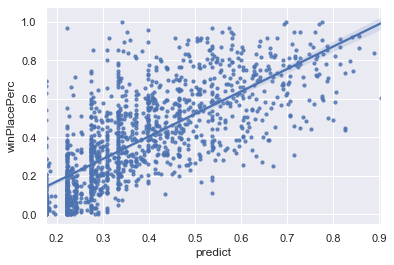

In [62]:
data1_unranked_solo['predict']=model_unranked_solo.predict(data1_unranked_solo)
sns.regplot(x = "predict", y = "winPlacePerc", data = data1_unranked_solo, scatter_kws = {'s':10})

언랭 - 듀오모드

<ipython-input-63-dc3a0a2073a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_unranked_duo['predict']=model_unranked_duo.predict(data1_unranked_duo)


<AxesSubplot:xlabel='predict', ylabel='winPlacePerc'>

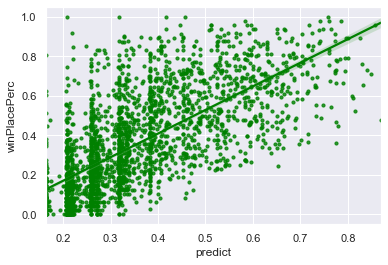

In [63]:
data1_unranked_duo['predict']=model_unranked_duo.predict(data1_unranked_duo)
sns.regplot(x = "predict", y = "winPlacePerc", data = data1_unranked_duo, scatter_kws = {'s':10}, color='green')

언랭 - 스쿼드모드

<ipython-input-64-0ea9df4c5c13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_unranked_squad['predict']=model_unranked_squad.predict(data1_unranked_squad)


<AxesSubplot:xlabel='predict', ylabel='winPlacePerc'>

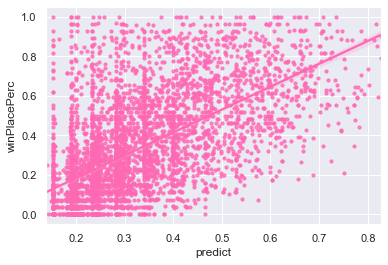

In [64]:
data1_unranked_squad['predict']=model_unranked_squad.predict(data1_unranked_squad)
sns.regplot(x = "predict", y = "winPlacePerc", data = data1_unranked_squad, scatter_kws = {'s':10}, color='hotpink')

-----

하위티어 - 솔로모드

<ipython-input-65-a70a6ef9d5ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_bottom_solo['predict']=model_bottom_solo.predict(data1_bottom_solo)


<AxesSubplot:xlabel='predict', ylabel='winPlacePerc'>

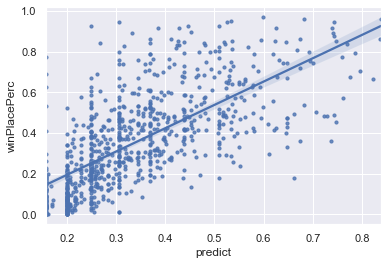

In [65]:
data1_bottom_solo['predict']=model_bottom_solo.predict(data1_bottom_solo)
sns.regplot(x = "predict", y = "winPlacePerc", data = data1_bottom_solo, scatter_kws = {'s':10})

하위티어 - 듀오모드

<ipython-input-66-c837d356c011>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_bottom_duo['predict']=model_bottom_duo.predict(data1_bottom_duo)


<AxesSubplot:xlabel='predict', ylabel='winPlacePerc'>

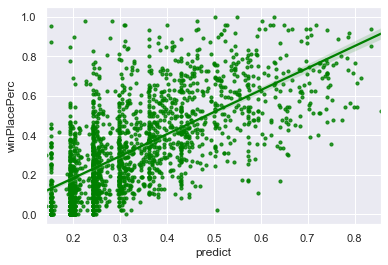

In [66]:
data1_bottom_duo['predict']=model_bottom_duo.predict(data1_bottom_duo)
sns.regplot(x = "predict", y = "winPlacePerc", data = data1_bottom_duo, scatter_kws = {'s':10}, color='green')

하위티어 - 스쿼드모드

<ipython-input-67-84d3ebf7a81f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_bottom_squad['predict']=model_bottom_squad.predict(data1_bottom_squad)


<AxesSubplot:xlabel='predict', ylabel='winPlacePerc'>

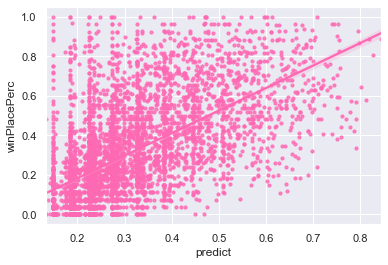

In [67]:
data1_bottom_squad['predict']=model_bottom_squad.predict(data1_bottom_squad)
sns.regplot(x = "predict", y = "winPlacePerc", data = data1_bottom_squad, scatter_kws = {'s':10}, color='hotpink')

----

중위티어 - 솔로모드

<ipython-input-68-3988baee5d92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mid_solo['predict']=model_mid_solo.predict(data1_mid_solo)


<AxesSubplot:xlabel='predict', ylabel='winPlacePerc'>

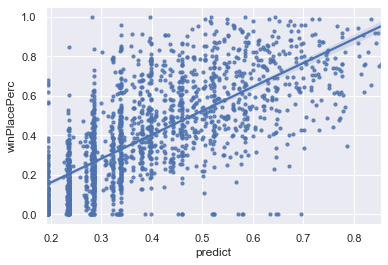

In [68]:
data1_mid_solo['predict']=model_mid_solo.predict(data1_mid_solo)
sns.regplot(x = "predict", y = "winPlacePerc", data = data1_mid_solo, scatter_kws = {'s':10})

중위티어 - 듀오모드

<ipython-input-69-da3dc6a68e2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mid_duo['predict']=model_mid_duo.predict(data1_mid_duo)


<AxesSubplot:xlabel='predict', ylabel='winPlacePerc'>

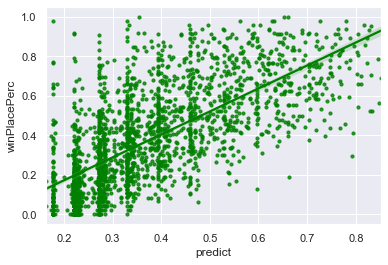

In [69]:
data1_mid_duo['predict']=model_mid_duo.predict(data1_mid_duo)
sns.regplot(x = "predict", y = "winPlacePerc", data = data1_mid_duo, scatter_kws = {'s':10}, color='green')

중위티어 - 스쿼드모드

<ipython-input-70-a2f5f8e1706c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mid_squad['predict']=model_mid_squad.predict(data1_mid_squad)


<AxesSubplot:xlabel='predict', ylabel='winPlacePerc'>

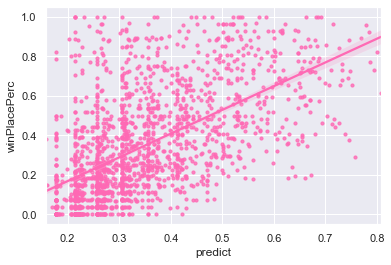

In [70]:
data1_mid_squad['predict']=model_mid_squad.predict(data1_mid_squad)
sns.regplot(x = "predict", y = "winPlacePerc", data = data1_mid_squad, scatter_kws = {'s':10}, color='hotpink')

상위티어의 경우 모든 모드를 합하여도 전체 약 440만개의 데이터 중 250여개밖에 없어 모델테스트를 수행하지 않음.

----

# Chapter 3. 프로그램 제작
<br>
모델 및 데이터를 이용하여 의미있는 프로그램 만들기.

### 1. 1킬의 가치 산정

    순쉬상승에 있어 1킬이 갖는 가치는 어느정도인지 다른 요인들을 통해 비교. 음수의 값은 해당 요소가 적을수록 좋다는 의미.

In [71]:
def kill_value():
    print('\033[33m'+'※ 순위상승에 있어 1킬의 값어치가 어느정도인지 알려주는 프로그램 입니다.'+'\033[0m')
    rp,m_type=input('\n\n랭크포인트(언랭인 경우에는 0), 매치타입(solo / duo / squad 중 1개 입력)을 입력해 주세요: ').replace(', ',',').split(',')  
    if int(rp)==0:
        if m_type=='solo':
            D=format(round(model_unranked_solo.params.kills/model_unranked_solo.params.damageDealt,2),".2f")
            B=format(round(model_unranked_solo.params.kills/model_unranked_solo.params.boosts,2),".2f")
            H=format(round(model_unranked_solo.params.kills/model_unranked_solo.params.heals,2),".2f")
            W=format(round(model_unranked_solo.params.kills/model_unranked_solo.params.weaponsAcquired,2),".2f")
            print('\n1킬은 '+'적에게 가한 피해량 '+'\033[34m'+'%s' %D+'\033[0m'+', 부스트아이템 '+'\033[34m'+'%s' %B+'\033[0m'+'개 사용, 회복아이템 '+'\033[34m'+'%s' %H+'\033[0m'+'개 사용, 무기 '+'\033[34m'+'%s' %W+'\033[0m'+'개 획득 만큼의 가치를 갖고 있습니다.')
        elif m_type=='duo':
            D=format(round(model_unranked_duo.params.kills/model_unranked_duo.params.damageDealt,2),".2f")
            B=format(round(model_unranked_duo.params.kills/model_unranked_duo.params.boosts,2),".2f")
            H=format(round(model_unranked_duo.params.kills/model_unranked_duo.params.heals,2),".2f")
            W=format(round(model_unranked_duo.params.kills/model_unranked_duo.params.weaponsAcquired,2),".2f")
            DB=format(round(model_unranked_duo.params.kills/model_unranked_duo.params.DBNOs,2),".2f")
            print('\n1킬은 '+'적에게 가한 피해량 '+'\033[34m'+'%s' %D+'\033[0m'+', 기절'+'\033[34m'+'%s' %DB+'\033[0m'+'회, 부스트아이템 '+'\033[34m'+'%s' %B+'\033[0m'+'개 사용, 회복아이템 '+'\033[34m'+'%s' %H+'\033[0m'+'개 사용, 무기 '+'\033[34m'+'%s' %W+'\033[0m'+'개 획득 만큼의 가치를 갖고 있습니다.')
        elif m_type=='squad':
            D=format(round(model_unranked_squad.params.kills/model_unranked_squad.params.damageDealt,2),".2f")
            B=format(round(model_unranked_squad.params.kills/model_unranked_squad.params.boosts,2),".2f")
            H=format(round(model_unranked_squad.params.kills/model_unranked_squad.params.heals,2),".2f")
            W=format(round(model_unranked_squad.params.kills/model_unranked_squad.params.weaponsAcquired,2),".2f")
            DB=format(round(model_unranked_squad.params.kills/model_unranked_squad.params.DBNOs,2),".2f")
            print('\n1킬은 '+'적에게 가한 피해량 '+'\033[34m'+'%s' %D+'\033[0m'+', 기절'+'\033[34m'+'%s' %DB+'\033[0m'+'회, 부스트아이템 '+'\033[34m'+'%s' %B+'\033[0m'+'개 사용, 회복아이템 '+'\033[34m'+'%s' %H+'\033[0m'+'개 사용, 무기 '+'\033[34m'+'%s' %W+'\033[0m'+'개 획득 만큼의 가치를 갖고 있습니다.')
    elif int(rp)<1500:
        if m_type=='solo':
            D=format(round(model_bottom_solo.params.kills/model_bottom_solo.params.damageDealt,2),".2f")
            B=format(round(model_bottom_solo.params.kills/model_bottom_solo.params.boosts,2),".2f")
            H=format(round(model_bottom_solo.params.kills/model_bottom_solo.params.heals,2),".2f")
            W=format(round(model_bottom_solo.params.kills/model_bottom_solo.params.weaponsAcquired,2),".2f")
            print('\n1킬은 '+'적에게 가한 피해량 '+'\033[34m'+'%s' %D+'\033[0m'+', 부스트아이템 '+'\033[34m'+'%s' %B+'\033[0m'+'개 사용, 회복아이템 '+'\033[34m'+'%s' %H+'\033[0m'+'개 사용, 무기 '+'\033[34m'+'%s' %W+'\033[0m'+'개 획득 만큼의 가치를 갖고 있습니다.')
        elif m_type=='duo':
            D=format(round(model_bottom_duo.params.kills/model_bottom_duo.params.damageDealt,2),".2f")
            B=format(round(model_bottom_duo.params.kills/model_bottom_duo.params.boosts,2),".2f")
            H=format(round(model_bottom_duo.params.kills/model_bottom_duo.params.heals,2),".2f")
            W=format(round(model_bottom_duo.params.kills/model_bottom_duo.params.weaponsAcquired,2),".2f")
            DB=format(round(model_bottom_duo.params.kills/model_bottom_duo.params.DBNOs,2),".2f")
            print('\n1킬은 '+'적에게 가한 피해량 '+'\033[34m'+'%s' %D+'\033[0m'+', 기절'+'\033[34m'+'%s' %DB+'\033[0m'+'회, 부스트아이템 '+'\033[34m'+'%s' %B+'\033[0m'+'개 사용, 회복아이템 '+'\033[34m'+'%s' %H+'\033[0m'+'개 사용, 무기 '+'\033[34m'+'%s' %W+'\033[0m'+'개 획득 만큼의 가치를 갖고 있습니다.')
        elif m_type=='squad':
            D=format(round(model_bottom_squad.params.kills/model_bottom_squad.params.damageDealt,2),".2f")
            B=format(round(model_bottom_squad.params.kills/model_bottom_squad.params.boosts,2),".2f")
            H=format(round(model_bottom_squad.params.kills/model_bottom_squad.params.heals,2),".2f")
            W=format(round(model_bottom_squad.params.kills/model_bottom_squad.params.weaponsAcquired,2),".2f")
            DB=format(round(model_bottom_squad.params.kills/model_bottom_squad.params.DBNOs,2),".2f")
            print('\n1킬은 '+'적에게 가한 피해량 '+'\033[34m'+'%s' %D+'\033[0m'+', 기절'+'\033[34m'+'%s' %DB+'\033[0m'+'회, 부스트아이템 '+'\033[34m'+'%s' %B+'\033[0m'+'개 사용, 회복아이템 '+'\033[34m'+'%s' %H+'\033[0m'+'개 사용, 무기 '+'\033[34m'+'%s' %W+'\033[0m'+'개 획득 만큼의 가치를 갖고 있습니다.')
    elif int(rp)<2500:
        if m_type=='solo':
            D=format(round(model_mid_solo.params.kills/model_mid_solo.params.damageDealt,2),".2f")
            B=format(round(model_mid_solo.params.kills/model_mid_solo.params.boosts,2),".2f")
            H=format(round(model_mid_solo.params.kills/model_mid_solo.params.heals,2),".2f")
            W=format(round(model_mid_solo.params.kills/model_mid_solo.params.weaponsAcquired,2),".2f")
            print('\n1킬은 '+'적에게 가한 피해량 '+'\033[34m'+'%s' %D+'\033[0m'+', 부스트아이템 '+'\033[34m'+'%s' %B+'\033[0m'+'개 사용, 회복아이템 '+'\033[34m'+'%s' %H+'\033[0m'+'개 사용, 무기 '+'\033[34m'+'%s' %W+'\033[0m'+'개 획득 만큼의 가치를 갖고 있습니다.')
        elif m_type=='duo':
            D=format(round(model_mid_duo.params.kills/model_mid_duo.params.damageDealt,2),".2f")
            B=format(round(model_mid_duo.params.kills/model_mid_duo.params.boosts,2),".2f")
            H=format(round(model_mid_duo.params.kills/model_mid_duo.params.heals,2),".2f")
            W=format(round(model_mid_duo.params.kills/model_mid_duo.params.weaponsAcquired,2),".2f")
            DB=format(round(model_mid_duo.params.kills/model_mid_duo.params.DBNOs,2),".2f")
            print('\n1킬은 '+'적에게 가한 피해량 '+'\033[34m'+'%s' %D+'\033[0m'+', 기절'+'\033[34m'+'%s' %DB+'\033[0m'+'회, 부스트아이템 '+'\033[34m'+'%s' %B+'\033[0m'+'개 사용, 회복아이템 '+'\033[34m'+'%s' %H+'\033[0m'+'개 사용, 무기 '+'\033[34m'+'%s' %W+'\033[0m'+'개 획득 만큼의 가치를 갖고 있습니다.')
        elif m_type=='squad':
            D=format(round(model_mid_squad.params.kills/model_mid_squad.params.damageDealt,2),".2f")
            B=format(round(model_mid_squad.params.kills/model_mid_squad.params.boosts,2),".2f")
            H=format(round(model_mid_squad.params.kills/model_mid_squad.params.heals,2),".2f")
            W=format(round(model_mid_squad.params.kills/model_mid_squad.params.weaponsAcquired,2),".2f")
            DB=format(round(model_mid_squad.params.kills/model_mid_squad.params.DBNOs,2),".2f")
            print('\n1킬은 '+'적에게 가한 피해량 '+'\033[34m'+'%s' %D+'\033[0m'+', 기절'+'\033[34m'+'%s' %DB+'\033[0m'+'회, 부스트아이템 '+'\033[34m'+'%s' %B+'\033[0m'+'개 사용, 회복아이템 '+'\033[34m'+'%s' %H+'\033[0m'+'개 사용, 무기 '+'\033[34m'+'%s' %W+'\033[0m'+'개 획득 만큼의 가치를 갖고 있습니다.')
    else:
        print('\033[33m'+'죄송합니다. 플래티넘 이상의 상위티어에서는 구현되지 않은 기능입니다.'+'\033[0m')

하위티어 솔로경기

In [72]:
kill_value()

※ 순위상승에 있어 1킬의 값어치가 어느정도인지 알려주는 프로그램 입니다.


랭크포인트(언랭인 경우에는 0), 매치타입(solo / duo / squad 중 1개 입력)을 입력해 주세요: 1009, solo

1킬은 적에게 가한 피해량 26.36, 부스트아이템 0.10개 사용, 회복아이템 0.79개 사용, 무기 0.13개 획득 만큼의 가치를 갖고 있습니다.


하위티어 스쿼드경기

In [73]:
kill_value()

※ 순위상승에 있어 1킬의 값어치가 어느정도인지 알려주는 프로그램 입니다.


랭크포인트(언랭인 경우에는 0), 매치타입(solo / duo / squad 중 1개 입력)을 입력해 주세요: 1200, squad

1킬은 적에게 가한 피해량 141.17, 기절-0.85회, 부스트아이템 0.29개 사용, 회복아이템 2.14개 사용, 무기 0.43개 획득 만큼의 가치를 갖고 있습니다.


중위티어 솔로경기

In [74]:
kill_value()

※ 순위상승에 있어 1킬의 값어치가 어느정도인지 알려주는 프로그램 입니다.


랭크포인트(언랭인 경우에는 0), 매치타입(solo / duo / squad 중 1개 입력)을 입력해 주세요: 2312, solo

1킬은 적에게 가한 피해량 -889.55, 부스트아이템 0.55개 사용, 회복아이템 4.63개 사용, 무기 0.80개 획득 만큼의 가치를 갖고 있습니다.


중위티어 스쿼드경기

In [75]:
kill_value()

※ 순위상승에 있어 1킬의 값어치가 어느정도인지 알려주는 프로그램 입니다.


랭크포인트(언랭인 경우에는 0), 매치타입(solo / duo / squad 중 1개 입력)을 입력해 주세요: 2275, squad

1킬은 적에게 가한 피해량 142.00, 기절-0.88회, 부스트아이템 0.34개 사용, 회복아이템 3.16개 사용, 무기 0.53개 획득 만큼의 가치를 갖고 있습니다.


----

### 2. 동 티어 대비 우수/미흡한 역량 분석

In [76]:
unrank_kill=data[data['rankPoints']==-1].kills.mean()
bronze_kill=data[(data['rankPoints']>0)&(data['rankPoints']<1500)].kills.mean()
silver_kill=data[(data['rankPoints']>1499)&(data['rankPoints']<2000)].kills.mean()
gold_kill=data[(data['rankPoints']>1999)&(data['rankPoints']<2500)].kills.mean()
platinum_kill=data[(data['rankPoints']>2499)&(data['rankPoints']<3000)].kills.mean()
diamond_kill=data[(data['rankPoints']>2999)&(data['rankPoints']<3500)].kills.mean()
master_kill=data[data['rankPoints']>3500].kills.mean()

unrank_damage=data[data['rankPoints']==-1].damageDealt.mean()
bronze_damage=data[(data['rankPoints']>0)&(data['rankPoints']<1500)].damageDealt.mean()
silver_damage=data[(data['rankPoints']>1499)&(data['rankPoints']<2000)].damageDealt.mean()
gold_damage=data[(data['rankPoints']>1999)&(data['rankPoints']<2500)].damageDealt.mean()
platinum_damage=data[(data['rankPoints']>2499)&(data['rankPoints']<3000)].damageDealt.mean()
diamond_damage=data[(data['rankPoints']>2999)&(data['rankPoints']<3500)].damageDealt.mean()
master_damage=data[data['rankPoints']>3500].damageDealt.mean()

unrank_heal=data[data['rankPoints']==-1].heals.mean()
bronze_heal=data[(data['rankPoints']>0)&(data['rankPoints']<1500)].heals.mean()
silver_heal=data[(data['rankPoints']>1499)&(data['rankPoints']<2000)].heals.mean()
gold_heal=data[(data['rankPoints']>1999)&(data['rankPoints']<2500)].heals.mean()
platinum_heal=data[(data['rankPoints']>2499)&(data['rankPoints']<3000)].heals.mean()
diamond_heal=data[(data['rankPoints']>2999)&(data['rankPoints']<3500)].heals.mean()
master_heal=data[data['rankPoints']>3500].heals.mean()

unrank_boost=data[data['rankPoints']==-1].boosts.mean()
bronze_boost=data[(data['rankPoints']>0)&(data['rankPoints']<1500)].boosts.mean()
silver_boost=data[(data['rankPoints']>1499)&(data['rankPoints']<2000)].boosts.mean()
gold_boost=data[(data['rankPoints']>1999)&(data['rankPoints']<2500)].boosts.mean()
platinum_boost=data[(data['rankPoints']>2499)&(data['rankPoints']<3000)].boosts.mean()
diamond_boost=data[(data['rankPoints']>2999)&(data['rankPoints']<3500)].boosts.mean()
master_boost=data[data['rankPoints']>3500].boosts.mean()

unrank_WA=data[data['rankPoints']==-1].weaponsAcquired.mean()
bronze_WA=data[(data['rankPoints']>0)&(data['rankPoints']<1500)].weaponsAcquired.mean()
silver_WA=data[(data['rankPoints']>1499)&(data['rankPoints']<2000)].weaponsAcquired.mean()
gold_WA=data[(data['rankPoints']>1999)&(data['rankPoints']<2500)].weaponsAcquired.mean()
platinum_WA=data[(data['rankPoints']>2499)&(data['rankPoints']<3000)].weaponsAcquired.mean()
diamond_WA=data[(data['rankPoints']>2999)&(data['rankPoints']<3500)].weaponsAcquired.mean()
master_WA=data[data['rankPoints']>3500].weaponsAcquired.mean()

In [77]:
def tips():
    print('\033[33m'+'※ 입력한 정보를 기반으로 플레이어님이 속한 랭크보다 뛰어난 점과 부족한 점을 분석해 주는 프로그램 입니다.'+'\033[0m')
    rp,kills,damage,heals,boosts,WA=input('\n\n랭크포인트(언랭인 경우에는 0), 평균 킬 수, 적에게 가한 평균 피해량,\n 회복아이템 평균 사용량, 부스트아이템 평균 사용량, 평균 무기습득량을 차례로 입력해 주세요 :'  ).replace(', ',',').split(',')  
    if int(rp)==0:
        df=pd.DataFrame({'처치 수' : [unrank_kill-float(kills)],
                      '적에게 가한 피해량' : [unrank_damage-float(damage)],
                      '회복아이템 사용량' : [unrank_heal-float(heals)],
                      '부스트아이템 사용량' : [unrank_boost-float(boosts)],
                      '무기 획득량' : [unrank_WA-float(WA)]}).transpose().sort_values(by=0)
        plus=[]; minus=[]
        for i in range(5):
            plus.append(df.index[i]) if float(df.values[i])<0 else minus.append(df.index[i])
        if len(plus)==0:
            print('\n'+'\033[31m'+'모든 부분'+'\033[0m'+'이 "언랭"티어의 평균보다 부족하시네요. 조금만 더 분발해 보는 것은 어떨까요?')
        elif len(minus)==0:
            print('\n'+'\033[32m'+'모든 부분'+'\033[0m'+'이 "언랭"티어의 평균보다 우수하시네요! 머지않아 상위티어로 올라가실 수 있을 것 같아요!!')
        else:
            minus.reverse()
            print('\n"언랭" 티어의 평균보다 '+'\033[32m'+'우수'+'\033[0m'+'한 역량: '+'\033[32m'+", ".join(plus)+'\033[0m')
            print('\n"언랭" 티어의 평균에 비해 '+'\033[31m'+'부족'+'\033[0m'+'한 역량: '+'\033[31m'+", ".join(minus)+'\033[0m')
    elif int(rp)<1500:
        df=pd.DataFrame({'처치 수' : [bronze_kill-float(kills)],
                        '적에게 가한 피해량' : [bronze_damage-float(damage)],
                        '회복아이템 사용량' : [bronze_heal-float(heals)],
                        '부스트아이템 사용량' : [bronze_boost-float(boosts)],
                        '무기 획득량' : [bronze_WA-float(WA)]}).transpose().sort_values(by=0)
        plus=[]; minus=[]
        for i in range(5):
            plus.append(df.index[i]) if float(df.values[i])<0 else minus.append(df.index[i])
        if len(plus)==0:
            print('\n'+'\033[31m'+'모든 부분'+'\033[0m'+'이 "브론즈"티어의 평균보다 부족하시네요. 조금만 더 분발해 보는 것은 어떨까요?')
        elif len(minus)==0:
            print('\n'+'\033[32m'+'모든 부분'+'\033[0m'+'이 "브론즈"티어의 평균보다 우수하시네요! 머지않아 상위티어로 올라가실 수 있을 것 같아요!!')
        else:
            minus.reverse()
            print('\n"브론즈" 티어의 평균보다 '+'\033[32m'+'우수'+'\033[0m'+'한 역량: '+'\033[32m'+", ".join(plus)+'\033[0m')
            print('\n"브론즈" 티어의 평균에 비해 '+'\033[31m'+'부족'+'\033[0m'+'한 역량: '+'\033[31m'+", ".join(minus)+'\033[0m')
    elif int(rp)<2000:
        df=pd.DataFrame({'처치 수' : [silver_kill-float(kills)],
                        '적에게 가한 피해량' : [silver_damage-float(damage)],
                        '회복아이템 사용량' : [silver_heal-float(heals)],
                        '부스트아이템 사용량' : [silver_boost-float(boosts)],
                        '무기 획득량' : [silver_WA-float(WA)]}).transpose().sort_values(by=0)
        plus=[]; minus=[]
        for i in range(5):
            plus.append(df.index[i]) if float(df.values[i])<0 else minus.append(df.index[i])
        if len(plus)==0:
            print('\n'+'\033[31m'+'모든 부분'+'\033[0m'+'이 "실버"티어의 평균보다 부족하시네요. 조금만 더 분발해 보는 것은 어떨까요?')
        elif len(minus)==0:
            print('\n'+'\033[32m'+'모든 부분'+'\033[0m'+'이 "실버"티어의 평균보다 우수하시네요! 머지않아 상위티어로 올라가실 수 있을 것 같아요!!')
        else:
            minus.reverse()
            print('\n"실버" 티어의 평균보다 '+'\033[32m'+'우수'+'\033[0m'+'한 역량: '+'\033[32m'+", ".join(plus)+'\033[0m')
            print('\n"실버" 티어의 평균에 비해 '+'\033[31m'+'부족'+'\033[0m'+'한 역량: '+'\033[31m'+", ".join(minus)+'\033[0m')
    elif int(rp)<2500:
        df=pd.DataFrame({'처치 수' : [gold_kill-float(kills)],
                        '적에게 가한 피해량' : [gold_damage-float(damage)],
                        '회복아이템 사용량' : [gold_heal-float(heals)],
                        '부스트아이템 사용량' : [gold_boost-float(boosts)],
                        '무기 획득량' : [gold_WA-float(WA)]}).transpose().sort_values(by=0)
        plus=[]; minus=[]
        for i in range(5):
            plus.append(df.index[i]) if float(df.values[i])<0 else minus.append(df.index[i])
        if len(plus)==0:
            print('\n'+'\033[31m'+'모든 부분'+'\033[0m''이 "골드"티어의 평균보다 부족하시네요. 조금만 더 분발해 보는 것은 어떨까요?')
        elif len(minus)==0:
            print('\n'+'\033[32m'+'모든 부분'+'\033[0m'+'이 "골드"티어의 평균보다 우수하시네요! 머지않아 상위티어로 올라가실 수 있을 것 같아요!!')
        else:
            minus.reverse()
            print('\n"골드" 티어의 평균보다 '+'\033[32m'+'우수'+'\033[0m'+'한 역량: '+'\033[32m'+", ".join(plus)+'\033[0m')
            print('\n"골드" 티어의 평균에 비해 '+'\033[31m'+'부족'+'\033[0m'+'한 역량: '+'\033[31m'+", ".join(minus)+'\033[0m')     
    elif int(rp)<3000:
        df=pd.DataFrame({'처치 수' : [platinum_kill-float(kills)],
                        '적에게 가한 피해량' : [platinum_damage-float(damage)],
                        '회복아이템 사용량' : [platinum_heal-float(heals)],
                        '부스트아이템 사용량' : [platinum_boost-float(boosts)],
                        '무기 획득량' : [platinum_WA-float(WA)]}).transpose().sort_values(by=0)
        plus=[]; minus=[]
        for i in range(5):
            plus.append(df.index[i]) if float(df.values[i])<0 else minus.append(df.index[i])
        if len(plus)==0:
            print('\n\033[31m'+'※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.'+'\033[0m')
            print('\033[31m'+'모든 부분'+'\033[0m'+'이 "플래티넘"티어의 평균보다 부족하시네요. 조금만 더 분발해 보는 것은 어떨까요?')
        elif len(minus)==0:
            print('\n\033[31m'+'※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.'+'\033[0m')
            print('\033[32m'+'모든 부분'+'\033[0m'+'이 "플래티넘"티어의 평균보다 우수하시네요! 머지않아 상위티어로 올라가실 수 있을 것 같아요!!')
        else:
            minus.reverse()
            print('\n\033[31m'+'※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.'+'\033[0m')
            print('플래티넘" 티어의 평균보다 '+'\033[32m'+'우수'+'\033[0m'+'한 역량: '+'\033[32m'+", ".join(plus)+'\033[0m')
            print('\n"플래티넘" 티어의 평균에 비해 '+'\033[31m'+'부족'+'\033[0m'+'한 역량: '+'\033[31m'+", ".join(minus)+'\033[0m')
    elif int(rp)<3500:
        df=pd.DataFrame({'처치 수' : [diamond_kill-float(kills)],
                        '적에게 가한 피해량' : [diamond_damage-float(damage)],
                        '회복아이템 사용량' : [diamond_heal-float(heals)],
                        '부스트아이템 사용량' : [diamond_boost-float(boosts)],
                        '무기 획득량' : [diamond_WA-float(WA)]}).transpose().sort_values(by=0)
        plus=[]; minus=[]
        for i in range(5):
            plus.append(df.index[i]) if float(df.values[i])<0 else minus.append(df.index[i])
        if len(plus)==0:
            print('\n\033[31m'+'※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.'+'\033[0m')
            print('\033[31m'+'모든 부분'+'\033[0m'+'이 "다이아몬드"티어의 평균보다 부족하시네요. 조금만 더 분발해 보는 것은 어떨까요?')
        elif len(minus)==0:
            print('\n\033[31m'+'※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.'+'\033[0m')
            print('\033[32m'+'모든 부분'+'\033[0m'+'이 "다이아몬드"티어의 평균보다 우수하시네요! 머지않아 상위티어로 올라가실 수 있을 것 같아요!!')
        else:
            minus.reverse()
            print('\n\033[31m'+'※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.'+'\033[0m')
            print('"다이아몬드" 티어의 평균보다 '+'\033[32m'+'우수'+'\033[0m'+'한 역량: '+'\033[32m'+", ".join(plus)+'\033[0m')
            print('\n"다이아몬드" 티어의 평균에 비해 '+'\033[31m'+'부족'+'\033[0m'+'한 역량: '+'\033[31m'+", ".join(minus)+'\033[0m')
    else:
        df=pd.DataFrame({'처치 수' : [master_kill-float(kills)],
                        '적에게 가한 피해량' : [master_damage-float(damage)],
                        '회복아이템 사용량' : [master_heal-float(heals)],
                        '부스트아이템 사용량' : [master_boost-float(boosts)],
                        '무기 획득량' : [master_WA-float(WA)]}).transpose().sort_values(by=0)
        plus=[]; minus=[]
        for i in range(5):
            plus.append(df.index[i]) if float(df.values[i])<0 else minus.append(df.index[i])
        if len(plus)==0:
            print('\n\033[31m'+'※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.'+'\033[0m')
            print('\033[31m'+'모든 부분'+'\033[0m'+'이 "마스터"티어의 평균보다 부족하시네요. 조금만 더 분발해 보는 것은 어떨까요?')
        elif len(minus)==0:
            print('\n\033[31m'+'※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.'+'\033[0m')
            print('\033[32m'+'모든 부분'+'\033[0m'+'이'+ '"마스터"티어의 평균보다 우수하시네요! 당신은 배틀그라운드 최고의 실력자입니다!!')
        else:
            minus.reverse()
            print('\n\033[31m'+'※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.'+'\033[0m')
            print('"마스터" 티어의 평균보다 '+'\033[32m'+'우수'+'\033[0m'+'한 역량: '+'\033[32m'+", ".join(plus)+'\033[0m')
            print('\n"마스터" 티어의 평균에 비해 '+'\033[31m'+'부족'+'\033[0m'+'한 역량: '+'\033[31m'+", ".join(minus)+'\033[0m')

가상의 플레이어 정보를 입력하여 얻은 결과

In [78]:
tips()

※ 입력한 정보를 기반으로 플레이어님이 속한 랭크보다 뛰어난 점과 부족한 점을 분석해 주는 프로그램 입니다.


랭크포인트(언랭인 경우에는 0), 평균 킬 수, 적에게 가한 평균 피해량,
 회복아이템 평균 사용량, 부스트아이템 평균 사용량, 평균 무기습득량을 차례로 입력해 주세요 :1261, 0.8, 100, 0.6, 0.5, 3

"브론즈" 티어의 평균보다 우수한 역량: 적에게 가한 피해량, 처치 수

"브론즈" 티어의 평균에 비해 부족한 역량: 회복아이템 사용량, 무기 획득량, 부스트아이템 사용량


In [79]:
tips()

※ 입력한 정보를 기반으로 플레이어님이 속한 랭크보다 뛰어난 점과 부족한 점을 분석해 주는 프로그램 입니다.


랭크포인트(언랭인 경우에는 0), 평균 킬 수, 적에게 가한 평균 피해량,
 회복아이템 평균 사용량, 부스트아이템 평균 사용량, 평균 무기습득량을 차례로 입력해 주세요 :2132, 1.2, 130, 3.3, 2.1, 4

"골드" 티어의 평균보다 우수한 역량: 회복아이템 사용량, 부스트아이템 사용량

"골드" 티어의 평균에 비해 부족한 역량: 적에게 가한 피해량, 처치 수, 무기 획득량


마스터 티어라고 응답한 후, 브론즈티어의 데이터를 넣었을 때

In [80]:
tips()

※ 입력한 정보를 기반으로 플레이어님이 속한 랭크보다 뛰어난 점과 부족한 점을 분석해 주는 프로그램 입니다.


랭크포인트(언랭인 경우에는 0), 평균 킬 수, 적에게 가한 평균 피해량,
 회복아이템 평균 사용량, 부스트아이템 평균 사용량, 평균 무기습득량을 차례로 입력해 주세요 :3500, 0.5, 60, 0.3, 0.2, 1.1

※ 플래티넘 이상의 경우 결과가 정확하지 않을 수 있습니다.
모든 부분이 "마스터"티어의 평균보다 부족하시네요. 조금만 더 분발해 보는 것은 어떨까요?


언랭 티어라고 응답한 후, 마스터 티어의 데이터를 넣었을 때

In [81]:
tips()

※ 입력한 정보를 기반으로 플레이어님이 속한 랭크보다 뛰어난 점과 부족한 점을 분석해 주는 프로그램 입니다.


랭크포인트(언랭인 경우에는 0), 평균 킬 수, 적에게 가한 평균 피해량,
 회복아이템 평균 사용량, 부스트아이템 평균 사용량, 평균 무기습득량을 차례로 입력해 주세요 :0, 3.1, 260, 3.5, 3.1, 5

모든 부분이 "언랭"티어의 평균보다 우수하시네요! 머지않아 상위티어로 올라가실 수 있을 것 같아요!!


----

# END